<a href="https://colab.research.google.com/github/isabellacadisco/textsent-unimi-2023/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
import datasets
from datasets import load_dataset

In [5]:
datasets.logging.set_verbosity_error()


In [6]:
dataset = load_dataset("empathetic_dialogues")

Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

Dataset empathetic_dialogues downloaded and prepared to /root/.cache/huggingface/datasets/empathetic_dialogues/default/0.1.0/09bbeed3882a67db98c73952fb3c1c9a85af83dc78f81454c2454382fd03f6cf. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
X = pd.DataFrame(dataset['train'])

In [8]:
X.head(2)

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,


In [9]:
X.context.unique()

array(['sentimental', 'afraid', 'proud', 'faithful', 'terrified',
       'joyful', 'angry', 'sad', 'jealous', 'grateful', 'prepared',
       'embarrassed', 'excited', 'annoyed', 'lonely', 'ashamed', 'guilty',
       'surprised', 'nostalgic', 'confident', 'furious', 'disappointed',
       'caring', 'trusting', 'disgusted', 'anticipating', 'anxious',
       'hopeful', 'content', 'impressed', 'apprehensive', 'devastated'],
      dtype=object)

In [10]:
X.shape

(76673, 8)

In [14]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.6 MB/s eta 0:00:00


In [15]:
from transformers import AutoTokenizer
from nltk.tokenize import sent_tokenize

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [17]:
contexts, prompts, utterances = X.context.values, X.prompt.values, X.utterance.values
batch_prompts, batch_utterances, batch_contexts = [], [], []

for i, c in enumerate(contexts):
    p, u = prompts[i], utterances[i]
    batch_prompts.append(p)
    batch_utterances.append(u)
    batch_contexts.append(c)

In [18]:
from collections import Counter

In [19]:
emotions = pd.DataFrame(Counter(batch_contexts).most_common())#.head(6)
E = set(emotions[0])
sample_prompts, sample_utterances, sample_contexts = [], [], []
for i, c in enumerate(batch_contexts):
    if c in E:
        sample_contexts.append(c)
        sample_prompts.append(batch_prompts[i])
        sample_utterances.append(batch_utterances[i])
print(len(sample_contexts))



76673


In [20]:
encoded_inputs = tokenizer(
    sample_prompts, sample_utterances, truncation=True, padding=True)['input_ids']

In [21]:
sentence_id = 0
print(sample_prompts[sentence_id], sample_utterances[sentence_id], '\n')
print('tokens', '=>', encoded_inputs[sentence_id][:6])
decoded_text = tokenizer.decode(encoded_inputs[sentence_id])
print('decoded', '=>', decoded_text[:decoded_text.index('[PAD]')+12], '...')

I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world. I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world. 

tokens => [101, 146, 2676, 1280, 1106, 1103]
decoded => [CLS] I remember going to the fireworks with my best friend. There was a lot of people _ comma _ but it only felt like us in the world. [SEP] I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people _ comma _ we felt like the only people in the world. [SEP] [PAD] [PAD]  ...


In [22]:
def decode(encoded_text):
    decoded_text = tokenizer.decode(encoded_text)
    if '[PAD]' in decoded_text:
        text = decoded_text[:decoded_text.index('[PAD]')+12]
    else:
        text = decoded_text
    return text

In [23]:
emotions = {
    'Profile A': {'caring', 'nostalgic', 'sentimental'},
    'Profile B': {'angry', 'disappointed', 'furious'},
    'Profile C': {'content', 'excited', 'grateful'}
}

In [24]:
def get_corpus(emotions, contexts, encoded_docs):
    data = []
    for i, context in enumerate(contexts):
        if context in emotions:
            data.append(encoded_docs[i])
    return data

In [25]:
corpora = dict([
    (profile, get_corpus(emotions[profile], sample_contexts, encoded_inputs)) for profile in emotions.keys()])

In [26]:
for k, v in corpora.items():
    print(k, len(v))

Profile A 6477
Profile B 7490
Profile C 7637


In [27]:

corpora['Profile A'][0][:4]

[101, 146, 2676, 1280]

In [44]:
from nltk import ngrams

In [51]:
from collections import defaultdict, Counter

import numpy as np
from nltk import ngrams, pad_sequence
from tqdm import tqdm


class NGramModel(object):
    """
    Assumes tokens as numerical indexes
    """

    def __init__(self, n=3, eos=102):
        self.ngrams = defaultdict(Counter)
        self.n = n
        self.eos = eos

    def count_ngrams(self, sentences):

        """ Collect ngram counts from corpus of sentences. """

        for sentence in tqdm(sentences):
            for ngram in ngrams(sentence, n=self.n, pad_left=True, left_pad_symbol=self.eos):
                prefix, next_word = ngram[:-1], ngram[-1]
                self.ngrams[tuple(prefix)][next_word] += 1

    def compute_log_prob(self, prefix):

        """ Compute log probabilities for a given prefix.
        Args:
            prefix List[str]: list of words
        Returns:
            dictinary of log probabilities : dict(tuple, float)
        """

        # if prefix is shorter than n-1 -> pad prefix to n-1 length
        prefix = tuple(pad_sequence(prefix,
                                    n=self.n - 1,
                                    pad_left=True,
                                    left_pad_symbol=0)
                       )
        # if prefix is longer than n-1 -> take the last n-1 grams
        prefix = prefix[-(self.n - 1):]

        # counts for all words that might follow the prefix
        next_word_counts = self.ngrams[prefix]

        # prefix is found among ngrams
        if len(next_word_counts) > 0:
            prefix_counts = sum(self.ngrams[prefix].values())
            return {next_word:
                        np.log(next_word_counts[next_word]) -
                        np.log(prefix_counts) for next_word in next_word_counts}

            # prefix never occurred in training corpus
        else:
            return {}

    def sample_next(self, prefix):
        """
        Sample the next token for a given prefix according to the frequency learned from data.
        Args:
            prefix: List[str]
        Returns:
            next token: int
        """
        next_word_prob = self.compute_log_prob(prefix)
        if len(next_word_prob) > 0:
            next_token, next_prob = next_word_prob.keys(), next_word_prob.values()
            end = np.random.choice(list(next_token), p=np.exp(list(next_prob)))
            return end
        return self.eos

    def eval_prob(self, sentence):
        p = float('-inf')
        for chunk in ngrams(sentence, n=self.n, pad_left=True, left_pad_symbol=self.eos):
            prefix = chunk[-self.n:-1]
            count = self.ngrams[prefix][chunk[-1]]
            if count > 0:
                p = np.log(count) - np.log(sum(self.ngrams[prefix].values()))
                p += p
        return p

In [45]:
example = [101, 2903, 143, 245]
print(list(ngrams(example, n=3, pad_left=True)))

[(None, None, 101), (None, 101, 2903), (101, 2903, 143), (2903, 143, 245)]


In [52]:
corpus = corpora['Profile A']
profile_models = NGramModel(n=3)
profile_models.count_ngrams([[x for x in y if x != 0] for y in corpus])

100%|██████████| 6477/6477 [00:01<00:00, 4165.81it/s]


In [53]:
prefix = tokenizer('I remember')['input_ids'][:-1]
log_p = pd.Series(profile_models.compute_log_prob(prefix))
for k, v in log_p.sort_values(ascending=False).head().items():
    print(k, decode([k]), v)

1165 when -1.0213964380007265
1103 the -1.9832976811269338
1139 my -2.070309058116563
1155 all -3.244428899292818
1280 going -3.244428899292818


In [54]:
next_token = profile_models.sample_next(prefix)
decode([next_token])

'being'

In [55]:
models = dict([(profile, NGramModel(n=3)) for profile in corpora.keys()])
for profile, model in models.items():
    model.count_ngrams([[x for x in y if x != 0] for y in corpora[profile]])

100%|██████████| 7637/7637 [00:00<00:00, 8461.12it/s]


In [56]:
def generate(profile, start_word):
    start, eos = 101, 102
    start_prefix = tokenizer(start_word)['input_ids'][1]
    prefix = [start, start_prefix]
    for i in range(100):
        next_token = models[profile].sample_next(prefix)
        if next_token == eos:
            break
        else:
            prefix.append(next_token)
    return prefix

In [57]:
for profile in corpora.keys():
    text = generate(profile, start_word="I")
    print(profile, ' : ', ", ".join(emotions[profile]))
    print(decode(text), '\n')

Profile A  :  caring, nostalgic, sentimental
[CLS] I went to the park almost every career available. Now he is starting high school _ comma _ when I was looking through my old baby book I made a long time? 

Profile B  :  furious, disappointed, angry
[CLS] I cant stand when i spilled my bowl of cereal? 

Profile C  :  content, excited, grateful
[CLS] I can't get enough of them. Sorry to hear. Being independent all your relatives have left after coming over for speeding. The store only gives out so many things we could splurge more often though. invest form the future? 



In [58]:
from nltk import ngrams

In [59]:
sentence = tokenizer('i wish i was looking through old pictures')['input_ids']
model = models['Profile C']
p = None
for chunk in ngrams(sentence, n=3, pad_left=True, left_pad_symbol=102):
    prefix = chunk[-3:-1]
    probs = model.compute_log_prob(prefix)
    final_word = chunk[-1]
    try:
        estimation = probs[final_word]
        if estimation != 0:
            if p is None:
                p = estimation
            else:
                p += estimation
    except KeyError:
        pass

In [60]:
p

-6.1446409152384085

In [61]:
def predict(profile, sentence_text):
    sentence = tokenizer(sentence_text)['input_ids']
    model = models[profile]
    return model.eval_prob(sentence)

def predict_tokens(profile, sentence):
    model = models[profile]
    return model.eval_prob(sentence)

In [62]:
predict('Profile A', 'i wish i was looking through old pictures')

-2.9932848365775113

In [63]:
predict('Profile B', 'i wish i was looking through old pictures')

0.0

In [64]:
predict('Profile C', 'i wish i was looking through old pictures')

-4.394449154672439

In [65]:
y_true, y_pred = [], []
profiles = list(corpora.keys())
run = list(corpora.items())
for profile, corpus in tqdm(run):
    for sentence in corpus:
        s = [x for x in sentence if x != 0]
        predictions = [predict_tokens(p, s) for p in profiles]
        y_pred.append(profiles[np.argmax(predictions)])
        y_true.append(profile)

100%|██████████| 3/3 [00:18<00:00,  6.21s/it]


In [66]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [67]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

   Profile A       0.44      0.58      0.50      6477
   Profile B       0.52      0.49      0.51      7490
   Profile C       0.54      0.42      0.48      7637

    accuracy                           0.50     21604
   macro avg       0.50      0.50      0.49     21604
weighted avg       0.51      0.50      0.49     21604



In [68]:
import matplotlib.pyplot as plt

In [69]:
cm = confusion_matrix(y_true, y_pred, labels=profiles)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=profiles)

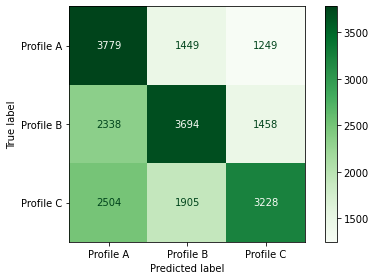

In [70]:
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

In [71]:
from itertools import islice

In [72]:
def compute_perplexity(model, dataset, max_iterations=1000):
    entropy = 0
    num_words, num_iter = 0, 0
    for i in range(max_iterations):
        for sentence in islice(dataset, max_iterations):
            sentence = [x for x in sentence if x != 0]
            prefix = [sentence[1]]
            for token in sentence[2:]:
                try:            
                    log_probs = model.compute_log_prob(prefix) 
                    entropy += log_probs[token]                 
                except KeyError:
                    entropy -= 100
                prefix.append(token)
                num_words += 1
    mean_entropy = entropy / num_words
    return np.exp(mean_entropy)

In [73]:
for profile in profiles:
    print(profile, ' : ', compute_perplexity(models[profile], corpora[profile], max_iterations=50))

Profile A  :  0.02361161425393916
Profile B  :  0.027951038947676452
Profile C  :  0.016482635134495247
